# MobileNet - Depthwise Seperable Convoltion

In [1]:
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CIFAR100
from torchvision import transforms
from torch.utils import data

import torch.optim as optim
import torch.nn as nn
import torchvision
import torch

import matplotlib.pyplot as plt
import numpy as np

BATCH_SIZE = 32

/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <F0D48035-EF9E-3141-9F63-566920E60D7C> /Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <44B645FB-F027-3EE5-86D7-DBF8E2FC6264> /Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
train_dataset = CIFAR100(root='../data/', train=True, download=True, transform=transforms.ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = CIFAR100(root='./data/', train=False, download=True, transform=transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Files already downloaded and verified


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data/


In [17]:
train_dataset.data[-1, :, :, ].shape

(32, 32, 3)

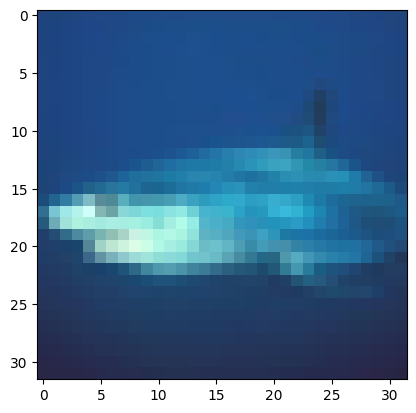

In [18]:
plt.imshow(train_dataset.data[-1, :, :, ])
plt.show()

## Depthwise Convoltion

MobileNet에서 가장 중요하다고 하는 부분 중 일부인 Depthwise Convolution 은 Depthwise Seperable Convolution 의 일부 중 하나이다. 기존 모델과의 가장 큰 차이는 각 채널을 따로따로 연산하여 합친다는 것이다. 아래 코드를 통해 구현을 해보겠다.

In [4]:
class DepthwiseConv(nn.Module):
    def __init__(self):
        super(DepthwiseConv, self).__init__()
        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

    def forward(self, x):
        x1, x2, x3 = x[:, :, :, 0], x[:, :, :, 1], x[:, :, :, 2]
        x1 = self.depthwise_conv(x1)
        x2 = self.depthwise_conv(x2)
        x3 = self.depthwise_conv(x3)
        x = torch.cat((x1, x2, x3), dim=3)
        return x


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


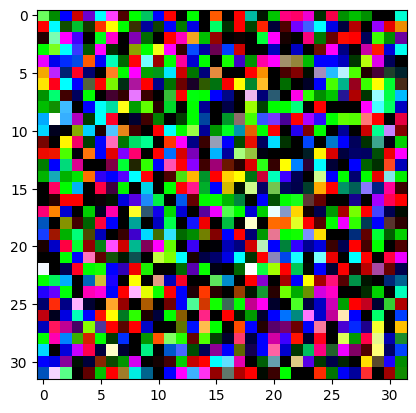

In [31]:
simple_img_data = torch.randn((1, 3, 32, 32))
plt.imshow(simple_img_data.view(32, 32, 3))
plt.show()

In [47]:
depthwise_simple_64 = nn.Sequential(
    nn.Conv2d(1, 32, 3, stride=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
)

simple_data_1 = simple_img_data[:, 0, :, :, ].view(1, 1, 32, 32)     # R
simple_data_2 = simple_img_data[:, 1, :, :, ].view(1, 1, 32, 32)     # G
simple_data_3 = simple_img_data[:, 2, :, :, ].view(1, 1, 32, 32)     # B
print(simple_data_1.shape, simple_data_2.shape, simple_data_3.shape)

torch.Size([1, 1, 32, 32]) torch.Size([1, 1, 32, 32]) torch.Size([1, 1, 32, 32])


In [48]:
output_1 = depthwise_simple_64(simple_data_1)
output_2 = depthwise_simple_64(simple_data_2)
output_3 = depthwise_simple_64(simple_data_3)
print(output_1.shape, output_2.shape, output_3.shape)

concated_output = torch.cat((output_1, output_2, output_3))
print(concated_output.shape)

torch.Size([1, 32, 30, 30]) torch.Size([1, 32, 30, 30]) torch.Size([1, 32, 30, 30])
torch.Size([3, 32, 30, 30])


In [49]:
pointwise_simple = nn.Sequential(
    nn.Conv2d(32, 32, 1, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
)

output_4 = pointwise_simple(concated_output)
print(output_4.shape)

torch.Size([3, 32, 32, 32])
